## Topology

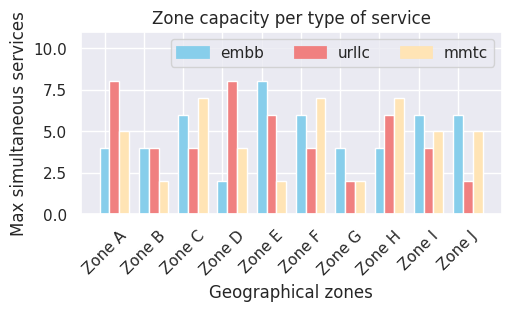

In [1]:
from plot_topology import plot_type_capacity,plot_an_capacity_per_type
from pathlib import Path
# Note : the topology differ based on : 
# 1. The random seed used
# 2. The behaviors of participant (due to the placement of participant in different zones).
# A single seed instead of a global average is used so we can see how heteregenous the topology is. 
exponential = Path(f"../results/fuzzy/base/exponential/0/")
outpath  ='../plotter/fuzzy/capacity_base.pdf'


plot_an_capacity_per_type(exponential ,"Zone capacity per type of service", outpath=outpath)


## Fuzzy explanation

/tmp/ipykernel_61861/3767104922.py:65: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l_handle in ax.legend_.legendHandles:
/tmp/ipykernel_61861/3767104922.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_61861/3767104922.py:106: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l_handle in ax.legend_.legendHandles:
/tmp/ipykernel_61861/3767104922.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


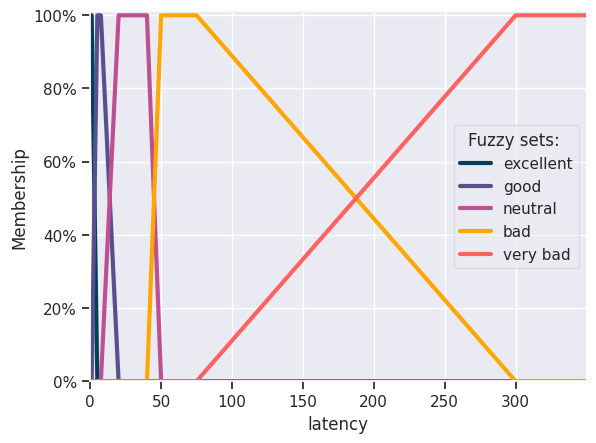

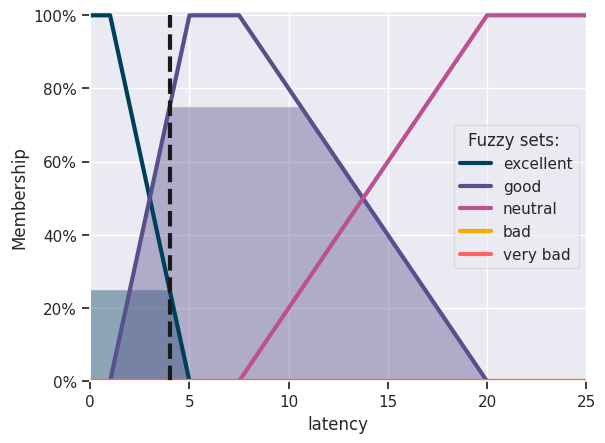

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import rcParams
import matplotlib.ticker as mtick


import skfuzzy as fuzz
from skfuzzy import control as ctrl
from skfuzzy.control.visualization import FuzzyVariableVisualizer

## Antecedents 
u_latency = np.arange(0, 350, 0.1)
latency = ctrl.Antecedent(u_latency, 'latency')

u_loss = np.arange(0, 100000, 1)
loss = ctrl.Antecedent(u_loss, 'loss')

u_bandwith = np.arange(0, 1000, 1)
bandwith = ctrl.Antecedent(u_bandwith, 'bandwith')

## Consequent 
trust = ctrl.Consequent(np.arange(0.0, 1.0, 0.01), 'trust')

## Antecedents membership functions 
latency["excellent"]= fuzz.trapmf(u_latency, [0.0, 0, 1, 5.0])
latency["good"]= fuzz.trapmf(u_latency, [1.0, 5.0, 7.5, 20.0])
latency["neutral"]= fuzz.trapmf(u_latency, [7.5, 20, 40, 50])
latency["bad"]= fuzz.trapmf(u_latency, [40, 50, 75, 300])
latency["very bad"]= fuzz.trapmf(u_latency, [75, 300,350,350])

bandwith["very bad"] = fuzz.trapmf(u_bandwith, [1, 1,1,10])
bandwith["bad"] = fuzz.trapmf(u_bandwith, [1, 10, 50, 100])
bandwith["neutral"] = fuzz.trapmf(u_bandwith, [50, 100, 100, 300])
bandwith["good"] = fuzz.trapmf(u_bandwith, [100, 300, 500, 750])
bandwith["excellent"] = fuzz.trapmf(u_bandwith, [500, 750, 1000, 1000])

loss["excellent"] = fuzz.trapmf(u_loss,[10000,50000,100000,100000])
loss["good"] = fuzz.trapmf(u_loss, [1000,5000,10000,50000])
loss["neutral"] = fuzz.trapmf(u_loss, [500,1000,1000,5000])
loss["bad"] = fuzz.trapmf(u_loss, [10,100,500 ,1000 ])
loss["very bad"] = fuzz.trapmf(u_loss, [0,0 ,10,100])

## Consequent membership functions 
trust["excellent"] = fuzz.trimf(trust.universe, [0.75,1.0,1.0])
trust["good"] = fuzz.trimf(trust.universe, [0.5,0.75,1.0])
trust["neutral"] = fuzz.trimf(trust.universe, [0.25,0.5,0.75])
trust["bad"] =  fuzz.trimf(trust.universe, [0.0,0.25,0.5])
trust["very bad"] = fuzz.trimf(trust.universe, [0.0,0.0,0.25])

rcParams.update({"font.size": 16})
# linewidth
l = 5

# color palette 
custom_palette = ['#003f5c', '#58508d', '#bc5090', '#ffa600', '#ff6361'] 
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=custom_palette)


# Accessing directly FuzzyVariableVisualizer from skfuzzy allow further graph customization
fig, ax = FuzzyVariableVisualizer(latency).view()
for line in ax.lines:
    line.set_linewidth(3)
for l_handle in ax.legend_.legendHandles: 
    l_handle.set_linewidth(3)
    
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
ax.legend_._set_loc(5)
ax.legend_.set_title("Fuzzy sets: ")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
fig.savefig('../plotter/fuzzy/latency.pdf')
fig.show()

x_latency_zoomed = np.arange(0, 50, 0.1)
x_bandwith_zoomed = np.arange(0, 50, 0.1)
x_loss_zoomed = np.arange(0, 50, 0.1)

eMBB1 = ctrl.Rule(latency['excellent'] | latency['good'] | bandwith['excellent']|bandwith['good'], trust['excellent'])
eMBB2 = ctrl.Rule(latency['neutral'] | bandwith['neutral'], trust['neutral'])
eMBB3 = ctrl.Rule(bandwith['bad'] |bandwith['very bad'], trust['bad'])
eMBB4 = ctrl.Rule((latency['bad']|latency['very bad'])&(bandwith['bad'] |bandwith['very bad']), trust['very bad'])
eMBB5 = ctrl.Rule(latency['bad']|latency['very bad'], trust['bad'])
eMBB_trust_ctrl = ctrl.ControlSystem([eMBB1, eMBB2, eMBB3, eMBB4])
t = ctrl.ControlSystemSimulation(eMBB_trust_ctrl)

t.input['latency'] = 4
t.input['bandwith'] = 400
# trust.input['loss'] = 100

# Crunch the numbers
t.compute()
fuzz.interp_membership
# print(t.output['trust'])

fig, ax = FuzzyVariableVisualizer(latency).view(sim=t)
for line in ax.lines:
    if line._label == 'crisp value': 
        line.set_ydata([0,1.0])
        line.set_linestyle("dashed")
    line.set_linewidth(3)
ax.set_xlim([0, 25])
ax.legend_.set_title("Fuzzy sets: ")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

for l_handle in ax.legend_.legendHandles: 
    l_handle.set_linewidth(3)
fig.savefig('../plotter/fuzzy/latency_zoomed.pdf')
fig.show()


## Interactions analysis

But, regarder le nombre d'interaction par participants pour : 
1. S'assurer que le système que je propose soit un minimum fair
2. Regarder si les participants qui ont une réput pourie reçoivent quand même des interactions. 

### Outage

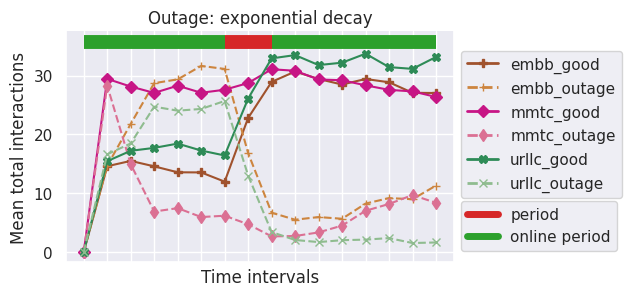

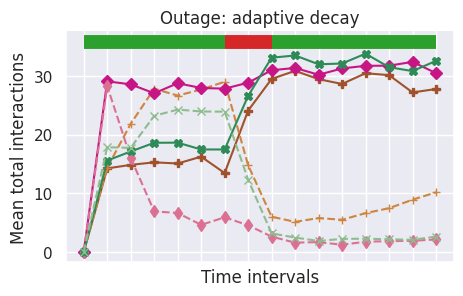

In [4]:
from pathlib import Path
from plot_label import plot_participant_interactions_overtime, plot_labels_interactions_overtime


scenario = "failure"

single = Path(f"../results/fuzzy/{scenario}/single/")
double = Path(f"../results/fuzzy/{scenario}/double/")
exponential = Path(f"../results/fuzzy/{scenario}/exponential/")

outpath_exp = "../plotter/fuzzy/evals/outage_exponential_mean_interactions.pdf"
outpath_adapt = "../plotter/fuzzy/evals/outage_adaptive_mean_interactions.pdf"


outage = [(6, 8)]

plot_labels_interactions_overtime(exponential, outage=outage, outpath=outpath_exp, title="Outage: exponential decay", small=True, multiseed=True)
plot_labels_interactions_overtime(double, outage=outage, outpath=outpath_adapt, title="Outage: adaptive decay", print_legend=False,small=True, multiseed=True)
# plot_labels_interactions_overtime(single, outage=outage, title="Outage: single window",small=True, multiseed=True)


### oscillating

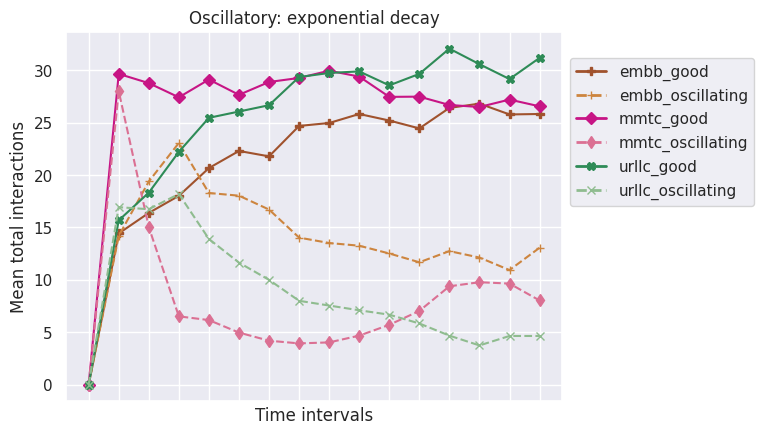

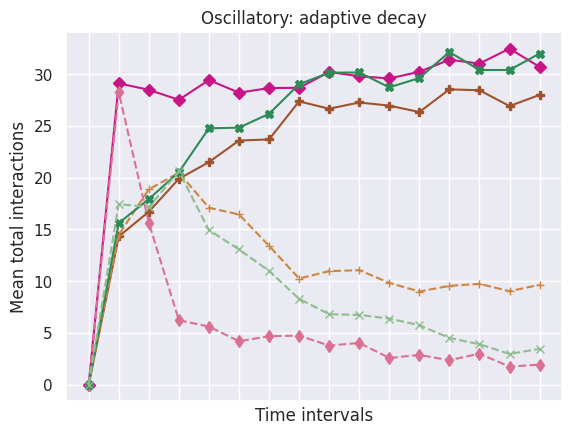

In [5]:
from pathlib import Path
from plot_label import plot_labels_interactions_overtime


scenario = "oscillating"

single = Path(f"../results/fuzzy/{scenario}/single/")
double = Path(f"../results/fuzzy/{scenario}/double/")
exponential = Path(f"../results/fuzzy/{scenario}/exponential/")

outpath_exp = "../plotter/fuzzy/evals/oscillating_exponential_mean_interactions.pdf"
outpath_adapt = "../plotter/fuzzy/evals/oscillating_adaptive_mean_interactions.pdf"

plot_labels_interactions_overtime(exponential, title="Oscillatory: exponential decay", outpath=outpath_exp ,multiseed=True)
plot_labels_interactions_overtime(double, title="Oscillatory: adaptive decay", outpath=outpath_adapt, print_legend=False,multiseed=True)



## Total negative interactions

### base case

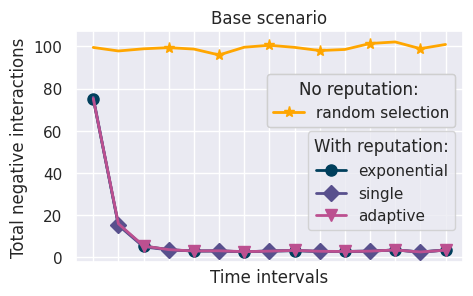

In [6]:
from plot_label import plot_negative_interactions_overtime,plot_negative_interactions_overtime_no_reput
from pathlib import Path

single = Path(f"../results/fuzzy/base/single/")
double = Path(f"../results/fuzzy/base/double/")
exponential = Path(f"../results/fuzzy/base/exponential/")
no_reput = Path(f"../results/fuzzy/base/no_reput/")
outpath = "../plotter/fuzzy/negative_interactions_no_reput.pdf"

labels_and_paths = [("With reputation:",[("exponential", exponential),("single", single),("adaptive", double)]),("No reputation: ",[("random selection", no_reput)])]

plot_negative_interactions_overtime_no_reput(labels_and_paths, 
    fuzzy=True, 
    multiseed=True, 
    title="Base scenario",
    outpath=outpath
    )


### failure

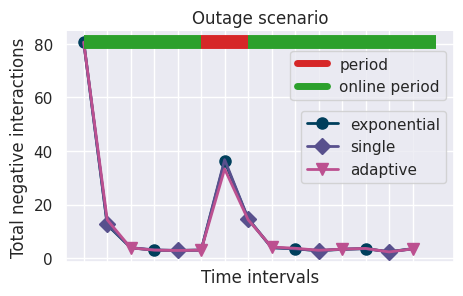

In [7]:
from plot_label import plot_negative_interactions_overtime,plot_cumulative_negative_interactions
from pathlib import Path
scenario = "failure"

single = Path(f"../results/fuzzy/{scenario}/single/")
double = Path(f"../results/fuzzy/{scenario}/double/")
exponential = Path(f"../results/fuzzy/{scenario}/exponential/")
outpath = "../plotter/fuzzy/outage_negative_interactions.pdf"

outage = [(5, 7)]

plot_negative_interactions_overtime([("exponential", exponential),("single", single),("adaptive", double)], fuzzy=True,outage = outage, outpath=outpath, title="Outage scenario", multiseed=True)

### Oscillatory

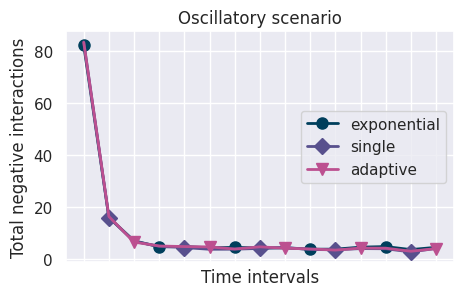

In [8]:
from plot_label import plot_negative_interactions_overtime 
from pathlib import Path
scenario = "oscillating"

single = Path(f"../results/fuzzy/{scenario}/single/")
double = Path(f"../results/fuzzy/{scenario}/double/")
exponential = Path(f"../results/fuzzy/{scenario}/exponential/")

outpath = "../plotter/fuzzy/oscillatory_negative_interactions.pdf"

plot_negative_interactions_overtime([("exponential", exponential),("single", single),("adaptive", double)], fuzzy=True, outpath=outpath, title="Oscillatory scenario",multiseed=True)


## Reputation monitoring

### No outage

In [9]:
from pathlib import Path
from plot_label import plot_reput_overtime


single = Path(f"../results/fuzzy/base/single/")
double = Path(f"../results/fuzzy/base/double/")
exponential = Path(f"../results/fuzzy/base/exponential/")

# plot_reput_overtime(single, title="Single window", multiseed=True)
# plot_reput_overtime(double, title="Adaptive window", multiseed=True)
# plot_reput_overtime(exponential, title="Exponential", multiseed=True)



### Outage

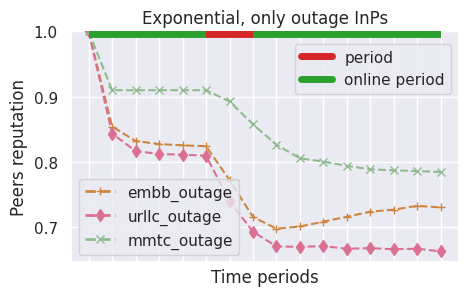

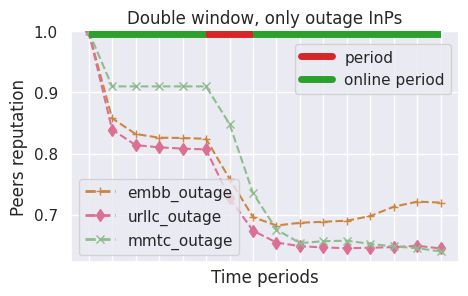

In [1]:
from pathlib import Path
from plot_label import plot_reput_overtime, plot_mean_reput_overtime


scenario = "failure"

single = Path(f"../results/fuzzy/{scenario}/single/")
double = Path(f"../results/fuzzy/{scenario}/double/")
exponential = Path(f"../results/fuzzy/{scenario}/exponential/")


outpath_exp = "../plotter/fuzzy/evals/outage_exponential_reputation.pdf"
outpath_adapt = "../plotter/fuzzy/evals/outage_adaptive_reputation.pdf"
outage = [(5, 7)]


# plot_reput_overtime(single, title="Single window, only outage InPs", labels_filter=["outage"], outage=outage, multiseed=True)
plot_mean_reput_overtime(exponential, title="Exponential, only outage InPs", out_path=outpath_exp, labels_filter=["outage"], outage=outage, multiseed=True)
plot_mean_reput_overtime(double, title="Double window, only outage InPs", out_path=outpath_adapt, labels_filter=["outage"], outage=outage, multiseed=True)


# Moyenne des participants. 
# Bon + mauvais en miroir vori plot_labels_interactions_overtime
# Un seul graph pour les deux avec une seule légende. 





### Oscillatory

In [2]:
from pathlib import Path
from plot_label import plot_reput_overtime


scenario = "oscillating"

single = Path(f"../results/fuzzy/{scenario}/single/")
double = Path(f"../results/fuzzy/{scenario}/double/")
exponential = Path(f"../results/fuzzy/{scenario}/exponential/")


# plot_reput_overtime(single, title="Single window, only outage InPs", labels_filter=["outage"], outage=outage, multiseed=True)
# plot_reput_overtime(exponential, title="Oscillating: exponential", multiseed=True)
# plot_reput_overtime(double, title="Oscillating: adaptive window", multiseed=True)
